### Single-input Network - PyTorch

Predicts the action given a single observation (checks whether the Dataset is 'difficult' to learn)

In [11]:
'''
Imports external and own libraries
'''

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

In [12]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)
    
with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)

In [13]:
'''
Use Dataloader to make the data ready for the training loop
'''

train_data, test_data = preprocess.split_data(tmaze_random_reverse_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'actions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'actions')

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

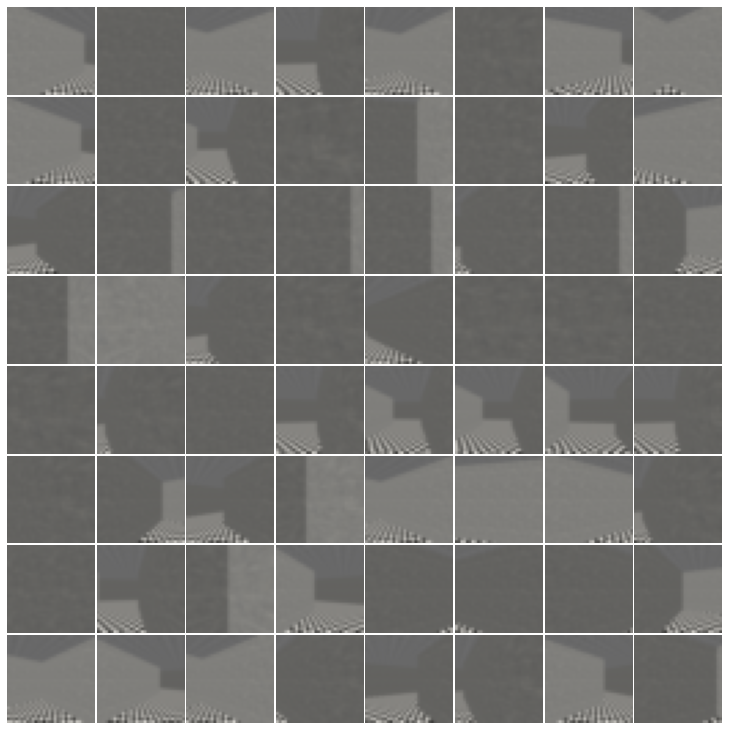

In [14]:
'''
Visualize one batch
'''

# next data part
dataiter = iter(dataset_loader_train_data)
# plot 64 examples
images, labels = dataiter.next()
plot.plot_64_observations(images)

In [16]:
'''
Feed-forward network
'''

forward = nets.Forward(64)
summary(forward, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 64]           5,440
Total params: 66,596
Trainable params: 66,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [ ]:
'''
Train the network
- best ever obtained training acc: 64% (test acc was at 17%) - for small dataset (2000)
- best obtained training acc: 
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(forward.parameters(), lr=0.001) #, momentum=0.9) # for small one 0.01 works well

episodes = 500
forward, train_loss, test_loss, train_acc, test_acc  = train.train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)


In [8]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)

NameError: name 'train_loss' is not defined

In [9]:
'''
Show example classifications and plot confusion matrix
'''

plot.show_example_classificataions(dataset_loader_train_data, forward, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, forward)

NameError: name 'forward' is not defined

In [10]:
'''
Save and load model
'''

# Save
torch.save(model, 'models/Feedforward_overfitted.pt')

# Load
#model = torch.load('models/Feedforward.pt')
#model.eval()

NameError: name 'model' is not defined

### Single-input Network - PyTorch (difference image)

In [17]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)
    
with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1, 1, 1, 2, 2]


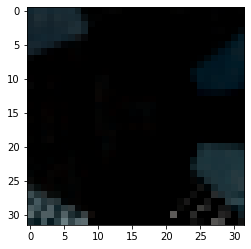

[1]
[2.164, 7.485]


In [18]:
k = 4

from matplotlib import pyplot as plt

img = []
act = []
for i in range(5):
    
    act.append(oracle_data['actions'][k + i])
    img.append(oracle_data['observations'][k + i])

print(act)

new = img[0] - img[4]

plt.imshow(new)
plt.show()

print([1])

coord = oracle_data['positions'][4]
x, _, y = coord
print([round(x, 3), round(y, 3)])

In [60]:
'''
Use Dataloader to make the data ready for the training loop
'''

with open('datasets/oracle_reversed_random_data_small.pickle', 'rb') as handle:
    oracle_reversed_random_data_small = pickle.load(handle)
# oracle_reversed_random_data_small - length 3000

n = 4
dataset = preprocess.split_n_steps_between(oracle_reversed_random_data_small, n=n)

single_class_encoding_dic = {}
counter = 0

if n == 1:
    for i in range(0, 4):
        single_class_encoding_dic[str([i])] = counter
        counter += 1
elif n == 2:
    for i in range(0, 4):
        for j in range(0, 4):
            single_class_encoding_dic[str([i, j])] = counter
            counter += 1
elif n == 3:
    for i in range(0, 4):
        for j in range(0, 4):
            for k in range(0, 4):
                single_class_encoding_dic[str([i, j, k])] = counter
                counter += 1
elif n == 4:
    for i in range(0, 4):
        for j in range(0, 4):
            for k in range(0, 4):
                for h in range(0, 4):
                    single_class_encoding_dic[str([i, j, k, h])] = counter
                    counter += 1

print(counter)

actions_recoded = []
for actions in dataset['actions']:
    actions_recoded.append([single_class_encoding_dic[str(actions)]]) # recode all actions
    
dataset['actions'] = actions_recoded

train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDualDataset(train_data, 'observationsA','observationsB', 'actions')
oracle_test_data = preprocess.ObtainDualDataset(test_data, 'observationsA','observationsB', 'actions')

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

print('done')

256
done


In [61]:
liste = [[1], [1], [2], [2], [3]]
print(Counter(liste))

TypeError: unhashable type: 'list'

In [80]:
actions = []
for element in train_data['actions']:
    actions.append(str(element[:]))
        
    

print(len(set(actions)))
d1 = Counter(actions)
count = 0
for key, value in d1.items():
    count += value
    
print('total train data', count)

actions = []
for element in test_data['actions']:
    actions.append(str(element[:]))
        

print(len(set(actions)))
d2 = Counter(actions)
count = 0
for key, value in d2.items():
    count += value
    
print('total train data', count)


d = {x:d1[x] for x in d1 if x not in d2}

print(d)

count = 0
for key, value in d.items():
    count += value
    
print('overlap total', count)
    

90
total train data 2397
78
total train data 599
{'[177]': 8, '[180]': 8, '[209]': 10, '[237]': 3, '[181]': 8, '[6]': 1, '[173]': 1, '[75]': 8, '[193]': 8, '[7]': 3, '[133]': 3, '[208]': 1, '[172]': 3, '[145]': 2, '[111]': 3, '[197]': 1}
overlap total 71


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


STEP  1
78
Counter({'[146]': 30, '[174]': 30, '[239]': 29, '[199]': 24, '[211]': 22, '[134]': 21, '[186]': 20, '[59]': 14, '[251]': 14, '[228]': 14, '[36]': 13, '[185]': 13, '[77]': 13, '[116]': 12, '[26]': 12, '[78]': 12, '[52]': 12, '[190]': 11, '[189]': 11, '[29]': 11, '[43]': 10, '[123]': 10, '[235]': 10, '[33]': 10, '[4]': 9, '[184]': 9, '[24]': 8, '[72]': 8, '[25]': 8, '[107]': 8, '[16]': 8, '[100]': 8, '[113]': 8, '[76]': 8, '[74]': 8, '[49]': 8, '[225]': 7, '[28]': 7, '[69]': 7, '[188]': 7, '[73]': 7, '[97]': 6, '[30]': 6, '[244]': 6, '[241]': 4, '[178]': 4, '[20]': 4, '[196]': 4, '[81]': 4, '[44]': 4, '[109]': 3, '[18]': 3, '[176]': 3, '[65]': 3, '[203]': 2, '[1]': 2, '[66]': 2, '[212]': 2, '[21]': 2, '[70]': 2, '[19]': 2, '[11]': 2, '[64]': 2, '[110]': 2, '[91]': 1, '[83]': 1, '[68]': 1, '[46]': 1, '[17]': 1, '[47]': 1, '[144]': 1, '[27]': 1, '[22]': 1, '[82]': 1, '[236]': 1, '[84]': 1, '[219]': 1, '[182]': 1})


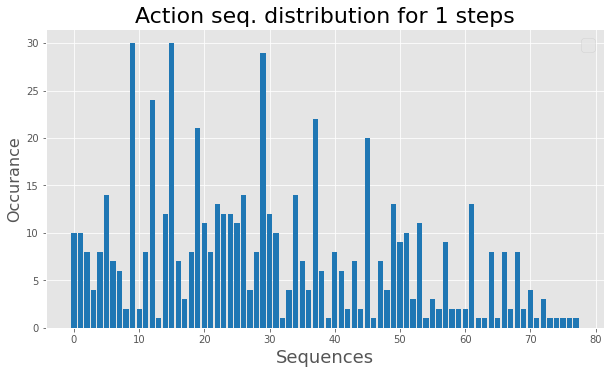

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 
STEP  2
78
Counter({'[146]': 30, '[174]': 30, '[239]': 29, '[199]': 24, '[211]': 22, '[134]': 21, '[186]': 20, '[59]': 14, '[251]': 14, '[228]': 14, '[36]': 13, '[185]': 13, '[77]': 13, '[116]': 12, '[26]': 12, '[78]': 12, '[52]': 12, '[190]': 11, '[189]': 11, '[29]': 11, '[43]': 10, '[123]': 10, '[235]': 10, '[33]': 10, '[4]': 9, '[184]': 9, '[24]': 8, '[72]': 8, '[25]': 8, '[107]': 8, '[16]': 8, '[100]': 8, '[113]': 8, '[76]': 8, '[74]': 8, '[49]': 8, '[225]': 7, '[28]': 7, '[69]': 7, '[188]': 7, '[73]': 7, '[97]': 6, '[30]': 6, '[244]': 6, '[241]': 4, '[178]': 4, '[20]': 4, '[196]': 4, '[81]': 4, '[44]': 4, '[109]': 3, '[18]': 3, '[176]': 3, '[65]': 3, '[203]': 2, '[1]': 2, '[66]': 2, '[212]': 2, '[21]': 2, '[70]': 2, '[19]': 2, '[11]': 2, '[64]': 2, '[110]': 2, '[91]': 1, '[83]': 1, '[68]': 1, '[46]': 1, '[17]': 1, '[47]': 1, '[144]': 1, '[27]': 1, '[22]': 1, '[82]': 1, '[236]': 1, '[84]': 1, '[219]': 1, '[182]': 1})


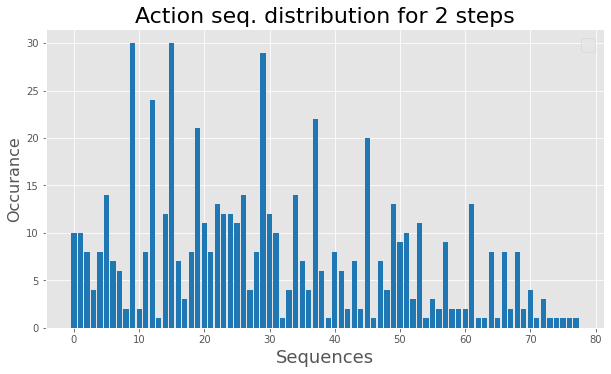

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


STEP  3
78
Counter({'[146]': 30, '[174]': 30, '[239]': 29, '[199]': 24, '[211]': 22, '[134]': 21, '[186]': 20, '[59]': 14, '[251]': 14, '[228]': 14, '[36]': 13, '[185]': 13, '[77]': 13, '[116]': 12, '[26]': 12, '[78]': 12, '[52]': 12, '[190]': 11, '[189]': 11, '[29]': 11, '[43]': 10, '[123]': 10, '[235]': 10, '[33]': 10, '[4]': 9, '[184]': 9, '[24]': 8, '[72]': 8, '[25]': 8, '[107]': 8, '[16]': 8, '[100]': 8, '[113]': 8, '[76]': 8, '[74]': 8, '[49]': 8, '[225]': 7, '[28]': 7, '[69]': 7, '[188]': 7, '[73]': 7, '[97]': 6, '[30]': 6, '[244]': 6, '[241]': 4, '[178]': 4, '[20]': 4, '[196]': 4, '[81]': 4, '[44]': 4, '[109]': 3, '[18]': 3, '[176]': 3, '[65]': 3, '[203]': 2, '[1]': 2, '[66]': 2, '[212]': 2, '[21]': 2, '[70]': 2, '[19]': 2, '[11]': 2, '[64]': 2, '[110]': 2, '[91]': 1, '[83]': 1, '[68]': 1, '[46]': 1, '[17]': 1, '[47]': 1, '[144]': 1, '[27]': 1, '[22]': 1, '[82]': 1, '[236]': 1, '[84]': 1, '[219]': 1, '[182]': 1})


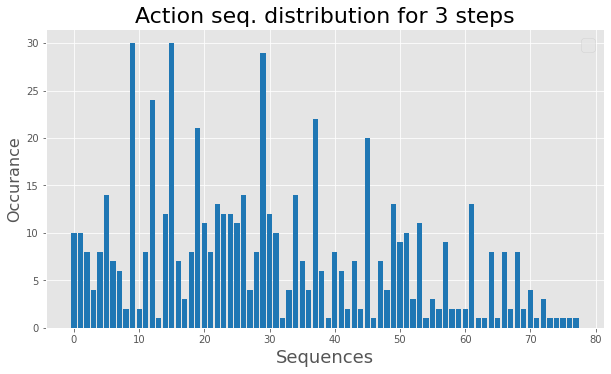

 
STEP  4
78
Counter({'[146]': 30, '[174]': 30, '[239]': 29, '[199]': 24, '[211]': 22, '[134]': 21, '[186]': 20, '[59]': 14, '[251]': 14, '[228]': 14, '[36]': 13, '[185]': 13, '[77]': 13, '[116]': 12, '[26]': 12, '[78]': 12, '[52]': 12, '[190]': 11, '[189]': 11, '[29]': 11, '[43]': 10, '[123]': 10, '[235]': 10, '[33]': 10, '[4]': 9, '[184]': 9, '[24]': 8, '[72]': 8, '[25]': 8, '[107]': 8, '[16]': 8, '[100]': 8, '[113]': 8, '[76]': 8, '[74]': 8, '[49]': 8, '[225]': 7, '[28]': 7, '[69]': 7, '[188]': 7, '[73]': 7, '[97]': 6, '[30]': 6, '[244]': 6, '[241]': 4, '[178]': 4, '[20]': 4, '[196]': 4, '[81]': 4, '[44]': 4, '[109]': 3, '[18]': 3, '[176]': 3, '[65]': 3, '[203]': 2, '[1]': 2, '[66]': 2, '[212]': 2, '[21]': 2, '[70]': 2, '[19]': 2, '[11]': 2, '[64]': 2, '[110]': 2, '[91]': 1, '[83]': 1, '[68]': 1, '[46]': 1, '[17]': 1, '[47]': 1, '[144]': 1, '[27]': 1, '[22]': 1, '[82]': 1, '[236]': 1, '[84]': 1, '[219]': 1, '[182]': 1})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


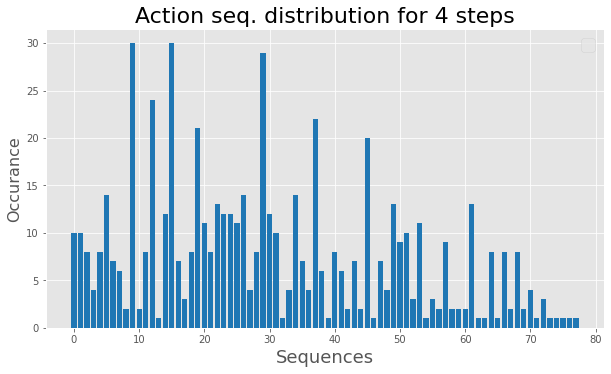

In [73]:
from collections import Counter


def show_information(dataset):

    actions = []
    for element in test_data['actions']:
        actions.append(str(element[:]))
        
    

    print(len(set(actions)))
    count = Counter(actions)
    print(count)
    
    plt.rcParams['figure.figsize'] = 10, 5.5
    with plt.style.context('ggplot'):
        plt.bar(range(len(count)), count.values(), color='tab:blue')
        string = 'Action seq. distribution for ' + str(i) + ' steps'
        plt.title(string, fontsize=22)
        plt.xlabel('Sequences', fontsize=18)
        plt.ylabel('Occurance', fontsize=16)
        plt.legend(fontsize=18)
        label = 'tmaze_random_reverse_data' + str(i) + '.png'
        #plt.savefig(label, bbox_inches='tight')
        plt.show()

for i in range(1, 5):
    with open('datasets/oracle_reversed_random_data_small.pickle', 'rb') as handle:
        oracle_reversed_random_data_small = pickle.load(handle)
    dataset = preprocess.split_n_steps_between(oracle_reversed_random_data_small, n=i)

    print('STEP ', str(i))
    show_information(dataset)
    print(' ')


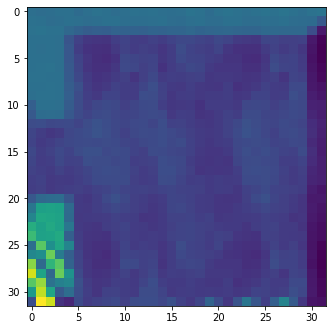

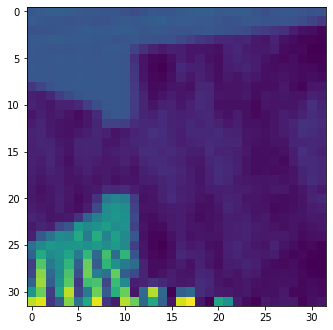

[211]


In [63]:
imagesA, imagesB, labels = next(iter(oracle_train_data))

from matplotlib import pyplot as plt

plt.imshow(imagesA[1])
plt.show()

plt.imshow(imagesB[1])
plt.show()

print(labels)

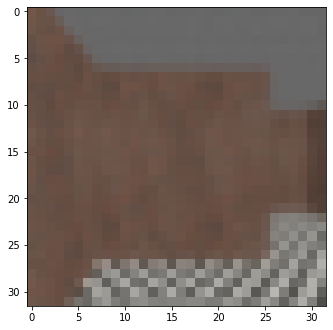

[1, 2, 0, 1]


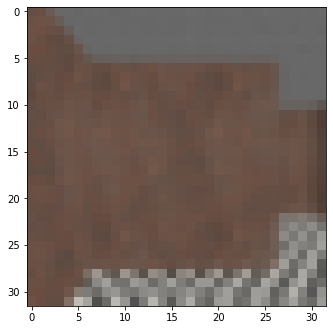

In [64]:
import torchvision
import torch
from matplotlib import pyplot as plt

classes_expl = {0: 'turn left', 1: 'turn right', 2: 'walk forwards', 3: 'walk backwards'}

index = 560

imageA = dataset['observationsA'][index]
imageB = dataset['observationsB'][index]
#lstval = [classes_expl[key] for key in dataset['actions'][index]]

plt.imshow(imageA)
plt.show()

print(dataset['actions'][index])

plt.imshow(imageB)
plt.show()

# look into tensor directly: plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [65]:
'''
Feed-forward network
'''

forward = nets.Forward(counter)
summary(forward, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                  [-1, 256]          21,760
Total params: 82,916
Trainable params: 82,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.32
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [66]:
import torch
import plot
from tqdm.auto import tqdm

import torchvision
from torch.utils.tensorboard import SummaryWriter

def train(train_data, val_data, net, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            train_correct = 0
            train_total = 0

            for i, data in enumerate(train_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputsA, inputsB, labels = data
                labels = labels[0]
                labels = labels.to(torch.long)
                
                inputs = inputsB - inputsA

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # compute acc
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0

                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        inputsA, inputsB, labels = data
                        labels = labels[0]
                        labels = labels.to(torch.long)
                        
                        inputs = inputsB - inputsA
                        
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
                        test_running_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        test_total += labels.size(0)
                        test_correct += (predicted == labels).sum().item()

            train_loss.append(train_running_loss/len(train_data))
            test_loss.append(test_running_loss/len(val_data))
            train_acc.append(100 * train_correct / train_total)
            test_acc.append(100 * test_correct / test_total)
            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train Acc: {(100 * train_correct / train_total):.4} %,  Test Loss: {(test_running_loss/len(val_data)):.4}, Test Acc: {(100 * test_correct / test_total):.4} %,')

    print('Finished Training')
    return net, train_loss, test_loss, train_acc, test_acc

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(forward.parameters(), lr=0.001) #, momentum=0.9) # for small one 0.01 works well

episodes = 500
forward, train_loss, test_loss, train_acc, test_acc  = train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 5.395, Train Acc: 1.877 %,  Test Loss: 4.947, Test Acc: 1.002 %,
Epoch: 11, Train Loss: 3.832, Train Acc: 6.8 %,  Test Loss: 3.84, Test Acc: 6.01 %,
Epoch: 21, Train Loss: 3.048, Train Acc: 13.14 %,  Test Loss: 3.375, Test Acc: 6.845 %,
Epoch: 31, Train Loss: 2.598, Train Acc: 19.4 %,  Test Loss: 3.231, Test Acc: 13.36 %,
Epoch: 41, Train Loss: 2.326, Train Acc: 24.11 %,  Test Loss: 3.264, Test Acc: 13.69 %,
Epoch: 51, Train Loss: 2.112, Train Acc: 28.79 %,  Test Loss: 3.393, Test Acc: 13.36 %,
Epoch: 61, Train Loss: 1.922, Train Acc: 33.38 %,  Test Loss: 3.681, Test Acc: 13.69 %,
Epoch: 71, Train Loss: 1.761, Train Acc: 37.34 %,  Test Loss: 3.87, Test Acc: 13.19 %,
Epoch: 81, Train Loss: 1.627, Train Acc: 42.68 %,  Test Loss: 4.112, Test Acc: 13.52 %,
Epoch: 91, Train Loss: 1.528, Train Acc: 45.18 %,  Test Loss: 4.444, Test Acc: 15.03 %,
Epoch: 101, Train Loss: 1.454, Train Acc: 47.39 %,  Test Loss: 4.957, Test Acc: 11.69 %,
Epoch: 111, Train Loss: 1.351, Train A

In [ ]:
def plot_losses(test_loss, train_loss):
    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 7))
        #plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 16})
        plt.plot(test_loss, color='slategray', linewidth=2)
        plt.plot(train_loss, color='red', linewidth=2)
        plt.legend(['Training Loss', 'Validation Loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.show()

def plot_acc(test_acc, train_acc, smooth=False):

    if smooth:
        test_acc_smoothed = savgol_filter(test_acc, 30, 12)  # window size, polynomial order
        train_acc_smoothed = savgol_filter(train_acc, 30, 12)

    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 7))
        #plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 16})
        if smooth:
            plt.plot(test_acc_smoothed, color='slategray', linewidth=2)
            plt.plot(train_acc_smoothed, color='red', linewidth=2)
        else:
            plt.plot(test_acc, color='slategray', linewidth=2)
            plt.plot(train_acc, color='red', linewidth=2)
        plt.legend(['Training Acc', 'Validation Acc'])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy in %')
        plt.title('Accuracy')
        plt.show()

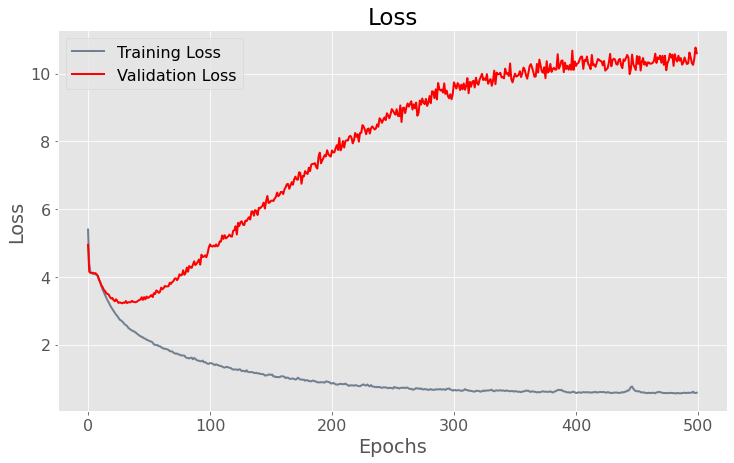

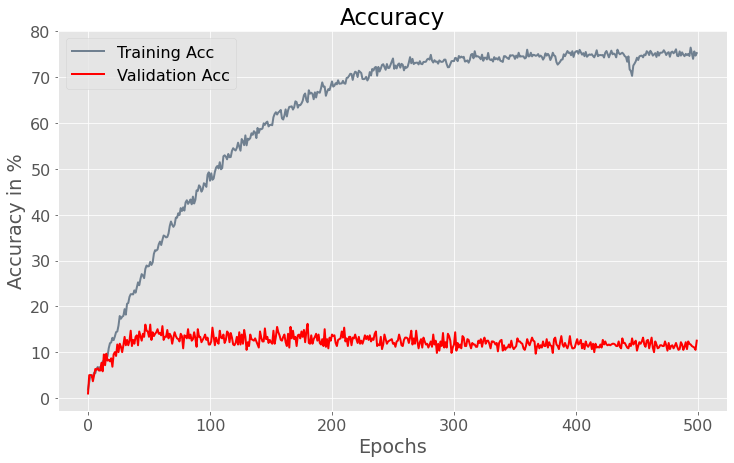

In [68]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=False)